In this notebook we'll show you how to use bayesianization for adversarial attack detection.

In [1]:
import os
os.chdir('../..')

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from examples.casting.data import create_datasets
from eXNN.NetBayesianization import BasicBayesianWrapper

In [3]:
# download repository https://github.com/Med-AI-Lab/eXNN-task-casting-defects
# change ind_repo to the root of the downloaded repository
ind_repo = Path('../eXNN-task-casting-defects')

In [4]:
# prepare data
_, test_ds = create_datasets(ind_repo / 'casting_512x512')
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

In [5]:
# prepare model
device = torch.device('cuda:0')
model = torch.load(ind_repo / 'trained_model.pt', map_location=device)
model = model.eval()

In [6]:
# define adversarial attack

def fgsm_attack(model, loss, images, labels, eps, device):
    
    images = images
    labels = labels
    images.requires_grad = True
    
    outputs = model.forward(images)
    
    model.zero_grad()
    cost = loss(outputs, labels).to(device)
    cost.backward()
    
    attack_images = images + eps*images.grad.sign()
    attack_images = torch.clamp(attack_images, 0, 1)
    
    return attack_images

Now we are going to show how to use bayesianization to detect an adversarial attack.

In [7]:
def _d(t: torch.Tensor): 
    return t.detach().cpu()

In [11]:
# build a bayesian version of the model
wrapper_model = BasicBayesianWrapper(model, "beta", p = None, a = 0.6, b = 12.0)

simple_res = {"acc": [], "uncert": []}
corrupted_res = {"acc": [], "uncert": []}

example_error = None
max_std = 0

# collect predictions
for i, img_data in enumerate(test_ds):
    img_data = test_ds[i]
    img, cls = img_data[0].to(device).unsqueeze(0), img_data[1]

    # make prediction on original data
    pred = wrapper_model.predict(img, n_iter = 10)
    pred_mean, pred_std = _d(pred["mean"]).argmax().item(), _d(pred["std"])
    simple_res["acc"].append(pred_mean == cls)
    simple_res["uncert"].append(pred_std.numpy())
    
    # make prediction on corrupted data
    corrupted_img = fgsm_attack(model, nn.NLLLoss(), img, 
                        torch.LongTensor([cls]).to(device), eps=0.01, device=device)
    corrupted_pred = wrapper_model.predict(corrupted_img, n_iter = 10)
    corrupted_pred_mean, corrupted_pred_std = _d(corrupted_pred["mean"]).argmax().item(), _d(corrupted_pred["std"])
    corrupted_res["acc"].append(corrupted_pred_mean == cls)
    corrupted_res["uncert"].append(corrupted_pred_std.numpy())
    
    # select example of the erroneous prediction with largest uncertainty for visual analysis
    if corrupted_pred_mean != pred_mean:
        if corrupted_pred_std.mean().item() > max_std:
            max_std = corrupted_pred_std.mean().item()
            example_error = [img.cpu().detach(), corrupted_img.cpu().detach(), 
                              {i: j.cpu().detach() for i, j in pred.items()},
                              {i: j.cpu().detach() for i, j in corrupted_pred.items()}]
    
    if (example_error is not None) and (i > 100):
        break

Let's look at the results

Firstly, let's compare uncertainty statistics on original and corrupted data

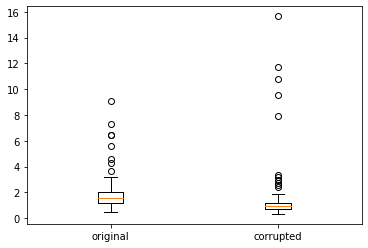

In [12]:
simple_data = np.array([np.mean(i) for i in simple_res["uncert"]])
corrupted_data = np.array([np.mean(i) for i in corrupted_res["uncert"]])

plt.boxplot([simple_data[simple_data < np.percentile(simple_data, 98)],
             corrupted_data[corrupted_data < np.percentile(corrupted_data, 98)]])
plt.xticks([1, 2], ["original", "corrupted"])
plt.plot();

Predictions on corrupted data have higher uncertainty and thus can be detected.

Now let's look at the sample on which the model made an erroneous prediction with largest uncertainty

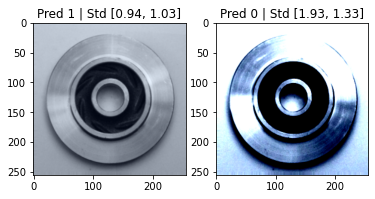

In [13]:
def viz_preproc(img):
    img = (img - img.min())/(img.max() - img.min() + 1e-8)
    img = img.cpu().detach().numpy()
    img = np.moveaxis(img, 0, -1)
    return img

fig, ax = plt.subplots(1, 2)
ax[0].imshow(viz_preproc(example_error[0].squeeze()))

pred = example_error[2]
mean, std = pred["mean"].argmax().tolist(), [round(i, 2) for i in pred["std"].squeeze().cpu().detach().tolist()]
ax[0].set_title("Pred {} | Std {}".format(mean, std))

ax[1].imshow(viz_preproc(example_error[1].squeeze()))

corrupted_pred = example_error[3]
mean, std = corrupted_pred["mean"].argmax().tolist(), [round(i, 2) for i in corrupted_pred["std"].squeeze().cpu().detach().tolist()]
ax[1].set_title("Pred {} | Std {}".format(mean, std))
plt.plot();

This example shows that adversarially corrupted example has highter uncertainty.